In [1]:
import pandas as pd

In [2]:
df = pd.DataFrame(columns=[
    "day", "month", "year", "hour",
    "client", 
    "solar_power_cat", "solar_power_num", 
    # columns that will contain either (feat) TemperatureC,DewpointC,PressurehPa,WindDirectionDegrees,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2
    # and significant negative contribution, negative contribution, positivie contribution and significant positive contribution
    "feat1", "feat2", "contri1", "contri2",
    # columns that will contain either none, no use, uncertain or use
    "air conditioner", "washing machine", "dishwasher", "water heater", "heater",
    "report"
])

df_meta = pd.read_csv("../GenerationCorpus/metadata.csv", index_col=0)

In [3]:
df_meta.head()

,date,client,solar_power_cat,solar_power_num,explanation,use_devices,uncertain_devices,nouse_devices,filename
0,"October 7th 2023, 15o'clock",Ema,high,10.143,"#('dewpoint', 'positive contribution')",#dishwasher&air conditioner,#,#water heater,report_1_1.txt
1,"June 8th 2023, 16o'clock",Ana,medium,2.800,"#('temperature', 'negative impact')",#heater,#washing machine,#air conditioner,report_1_2.txt
2,"February 27th 2023, 14o'clock",Ema,high,9.429,"#('dewpoint', 'positive contribution')&('tempe...",#heater&dishwasher&washing machine,#,#,report_1_3.txt
3,"November 28th 2023, 15o'clock",Ana,very high,13.857,"#('solar radiation', 'significant positive con...",#water heater&washing machine&dishwasher,#air conditioner,#,report_1_4.txt
4,"April 6th 2024, 6o'clock",Diana,low,3.429,"#('solar radiation', 'negative impact')&('hour...",#dishwasher,#,#air conditioner,report_1_5.txt


In [4]:
df.head()

,day,month,year,hour,client,solar_power_cat,solar_power_num,feat1,feat2,contri1,contri2,air conditioner,washing machine,dishwasher,water heater,heater,report


In [5]:
import string

def seperate_date(line):
    components = line["date"].split()
    month = components[0]
    raw_day = components[1]
    if raw_day[1] in string.ascii_lowercase:
        day = raw_day[0]
    else:
        day = raw_day[0:2]

    year = components[2][0:4]

    raw_hour = components[3]
    if raw_hour[1] in string.ascii_lowercase:
        hour = raw_hour[0]
    else:
        hour = raw_hour[0:2]

    return hour, day, month, year

def seperate_explanation(line):
    components = line["explanation"].split("&")
    new_components = []
    explanation = []
    for c in components:
        c = c.replace("#", "")
        c = c.replace("(", "")
        c = c.replace(")", "")
        c = c.replace("'", "")
        new_components = c.split(",")
        new_components[1] = new_components[1].replace(" ", "", 1)

        explanation.append(new_components)
    
    return explanation


def seperate_devices(line):
    component1 = line["use_devices"]
    component2 = line["uncertain_devices"]
    component3 = line["nouse_devices"]

    component1 = component1.split("&")
    component2 = component2.split("&")
    component3 = component3.split("&")

    devices = {
        "use": [],
        "uncertain": [],
        "no": []
    }
    for c1 in component1:
        c1 = c1.replace("#", "")
        devices["use"].append(c1)

    for c2 in component2:
        c2 = c2.replace("#", "")
        devices["uncertain"].append(c2)
    
    for c3 in component3:
        c3 = c3.replace("#", "")
        devices["no"].append(c3)

    return devices

In [6]:
for i in df_meta.index:
    row = {
        "day": "", "month": "", "year": "", "hour": "",
        "client": "", 
        "solar_power_cat": "", "solar_power_num": "", 
        "feat1": "", "feat2": "", "contri1": "", "contri2": "",
        "air conditioner": "", "washing machine": "", "dishwasher": "", "water heater": "", "heater": "",
        "report": ""
    }
    
    line = df_meta.iloc[i]
    hour, day, month, year = seperate_date(line)
    explanation = seperate_explanation(line)
    devices = seperate_devices(line)

    row["day"] = day
    row["month"] = month
    row["year"] = year
    row["hour"] = hour
    row["client"] = line["client"]
    row["solar_power_num"] = str(line["solar_power_num"])
    row["solar_power_cat"] = line["solar_power_cat"]
    count = 1
    for exp in explanation:
        row["feat" + str(count)] = exp[0]
        row["contri" + str(count)] = exp[1]

        count += 1

    level = 0
    for key in devices:
        for item in devices[key]:
            if not item == "":
                row[item] = str(level)
        
        level += 1
    
    f = open("../GenerationCorpus/corpus/" + line["filename"], "r")
    row["report"] = f.read()

    df.loc[len(df)] = row

df.head()

,day,month,year,hour,client,solar_power_cat,solar_power_num,feat1,feat2,contri1,contri2,air conditioner,washing machine,dishwasher,water heater,heater,report
0,7,October,2023,15,Ema,high,10.143,dewpoint,,positive contribution,,0,,0,2,,Report for Solar Power Predictions for Ema - O...
1,8,June,2023,16,Ana,medium,2.8,temperature,,negative impact,,2,1,,,0,"Dear Ana,\n\nWe hope this message finds you we..."
2,27,February,2023,14,Ema,high,9.429,dewpoint,temperature,positive contribution,positive contribution,,0,0,,0,"Dear Ema,\n\nWe hope this letter finds you wel..."
3,28,November,2023,15,Ana,very high,13.857,solar radiation,,significant positive contribution,,1,0,0,0,,"Dear Ana,\n\nI am pleased to present you with ..."
4,6,April,2024,6,Diana,low,3.429,solar radiation,hourly precipitation,negative impact,significant negative impact,2,,0,,,"Dear Diana,\n\nWe hope this message finds you ..."


In [7]:
df.to_csv("./nlp_data.csv")

In [8]:
lines = pd.read_csv("./nlp_data.csv")
a = " ".join(str(v) for v in lines.iloc[1].values[:-1])
print(a)

1 8 June 2023 16 Ana medium 2.8 temperature nan negative impact nan 2.0 1.0 nan nan 0.0


In [9]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

2023-04-13 17:57:02.149409: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 17:57:02.188633: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-13 17:57:02.189525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 17:57:02.771114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [11]:
lines = pd.read_csv("./nlp_data.csv")

context_raw = []
target_raw = []
for i in lines.index:
    context_raw.append(" ".join(str(v) for v in lines.iloc[i].values[1:-1]))
    target_raw.append(lines.iloc[i].values[-1])

context_raw = np.array(context_raw)
target_raw = np.array(target_raw)

print(context_raw)
print(target_raw)

print(len(context_raw[0]))
print(len(target_raw[0]))

['7 October 2023 15 Ema high 10.143 dewpoint nan positive contribution nan 0.0 nan 0.0 2.0 nan'
 '8 June 2023 16 Ana medium 2.8 temperature nan negative impact nan 2.0 1.0 nan nan 0.0'
 '27 February 2023 14 Ema high 9.429 dewpoint temperature positive contribution positive contribution nan 0.0 0.0 nan 0.0'
 '28 November 2023 15 Ana very high 13.857 solar radiation nan significant positive contribution nan 1.0 0.0 0.0 0.0 nan'
 '6 April 2024 6 Diana low 3.429 solar radiation hourly precipitation negative impact significant negative impact 2.0 nan 0.0 nan nan'
 '26 October 2023 14 Ana medium 3.733 hourly precipitation nan negative impact nan nan 2.0 nan 2.0 nan'
 '14 April 2024 11 Carlos very high 3.28 solar radiation temperature significant positive contribution positive contribution 0.0 0.0 nan nan 0.0'
 '14 June 2023 14 Ema high 2.48 dewpoint solar radiation positive contribution positive contribution nan nan 0.0 nan 0.0'
 '1 January 2024 15 Ema high 2.72 temperature nan positive cont

In [12]:
BUFFER_SIZE = 32000
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [13]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'28 August 2024 14 Rafael high 2.44 temperature solar radiation positive contribution positive contribution nan 0.0 0.0 nan nan'
 b'25 November 2023 15 Let\xc3\xadcia medium 2.08 temperature nan negative impact nan nan nan nan nan 0.0'
 b'3 June 2024 10 Carlos very high 12.286 temperature solar radiation positive contribution significant positive contribution 0.0 nan 0.0 nan nan'
 b'4 May 2024 13 Carlos very high 3.68 solar radiation nan significant positive contribution nan nan 0.0 0.0 0.0 nan'
 b'25 April 2023 10 Let\xc3\xadcia medium 7.0 hourly precipitation humidity negative impact negative impact nan 0.0 0.0 nan 2.0'], shape=(5,), dtype=string)

tf.Tensor(
[b'Dear Rafael,\n\nWe hope this message finds you well. We wanted to inform you of the solar power predictions for your solar panels on August 28th, 2024 at 2:00 PM.\n\nWe predict that the solar power generated will be high at this time, with an estimated power output of 2.44 kilo Watts. This positive forecast is du

2023-04-13 17:57:03.736596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [447]
	 [[{{node Placeholder/_1}}]]
2023-04-13 17:57:03.736835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [447]
	 [[{{node Placeholder/_0}}]]


In [14]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿0-9]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [15]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [16]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
print(len(context_text_processor.get_vocabulary()))
print(context_text_processor.get_vocabulary())

2023-04-13 17:57:03.902613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [447]
	 [[{{node Placeholder/_1}}]]
2023-04-13 17:57:03.903064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [447]
	 [[{{node Placeholder/_1}}]]


114
['', '[UNK]', '0', '.', 'nan', '2', '[START]', '[END]', 'negative', 'impact', '1', 'positive', 'contribution', '2024', '2023', 'significant', 'high', 'solar', 'radiation', 'temperature', 'very', 'low', 'medium', 'precipitation', 'hourly', '6', 'rain', 'daily', 'dewpoint', '8', '3', '4', '9', '12', '14', '10', '13', '18', 'february', '7', '20', 'diana', 'humidity', '5', '11', 'pedro', 'may', '17', '15', 'franciso', '16', 'tomas', 'september', 'luis', 'august', 'april', 'ana', 'march', '19', 'october', 'ricardo', 'june', 'rafael', 'november', 'january', 'constantino', 'carlos', 'december', 'leticia', 'ema', 'july', '28', '857', '429', '143', '23', '714', '286', '25', '26', '733', '22', '30', '267', '24', '571', '27', '133', '68', '067', '867', '333', '29', '21', '92', '76', '667', '56', '64', '36', '31', '933', '88', '533', '52', '467', '44', '04', '48', '08', '84', '72', '96', '32']


In [17]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
print(len(target_text_processor.get_vocabulary()))
print(target_text_processor.get_vocabulary())

2023-04-13 17:57:04.037503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [447]
	 [[{{node Placeholder/_0}}]]
2023-04-13 17:57:04.037761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [447]
	 [[{{node Placeholder/_1}}]]


1391
['', '[UNK]', ',', '.', 'the', 'power', 'to', 'you', 'solar', 'your', 'we', 'generated', 'this', 'that', 'and', 'on', 'of', 'predicted', 'will', 'at', 'a', 'is', 'for', 'as', 'panels', 'exceed', 'have', 'heater', 'be', 'any', 'with', '[START]', '[END]', 'tenergito', 'please', 'generation', 'it', 'hope', 'time', 'value', 'kilo', 'use', 'watts', 'or', 'report', 'if', 'dear', 'best', 'us', 'questions', 'during', 'regards', 'appliances', 'are', 'concerns', 'may', 'our', 'not', 'i', 'washing', 'due', 'machine', 'water', 'well', 'dishwasher', 'energy', 'air', 'can', 'impact', 'conditioner', 'finds', 'however', 'high', '2024', 'negative', 'provide', '2023', 'based', 'from', 'hesitate', 'in', 'using', 'message', 'prediction', 'inform', 'usage', 'without', 'recommend', 'radiation', 'wanted', 'thank', 'predictions', 'positive', 'by', 'do', 'information', 'temperature', 'contact', 'definitely', 'oclock', 'low', 'further', 'regarding', 'about', 'like', 'expected', 'would', 'might', 'contribut

In [18]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[6, 71, 54, 13, 34, 62, 16, 5, 3, 106, 19, 17, 18, 11, 12, 11, 12, 4, 2, 3,
  2, 2, 3, 2, 4, 4, 7]                                                      ,
 [6, 78, 63, 14, 48, 68, 22, 5, 3, 109, 19, 4, 8, 9, 4, 4, 4, 4, 4, 2, 3, 2,
  7]                                                                        ,
 [6, 30, 61, 13, 35, 66, 20, 16, 33, 3, 77, 19, 17, 18, 11, 12, 15, 11, 12,
  2, 3, 2, 4, 2, 3, 2, 4, 4, 7]                                            ]>

In [19]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] 28 august 2024 14 rafael high 2 . 44 temperature solar radiation positive contribution positive contribution nan 0 . 0 0 . 0 nan nan [END]'

Text(0.5, 1.0, 'Mask')

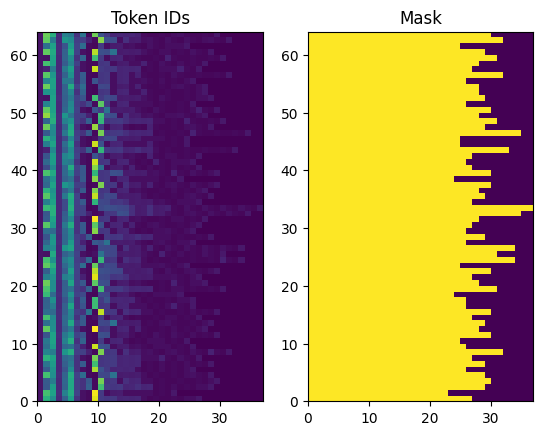

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [21]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [22]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[ 6 35 46 14 40 68 20 21  5  3]

[ 31  46 265   2  10  89   6 229 144 146]
[ 46 265   2  10  89   6 229 144 146  95]


2023-04-13 17:57:04.672709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype string
	 [[{{node Placeholder/_13}}]]
2023-04-13 17:57:04.673130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int64
	 [[{{node Placeholder/_14}}]]


In [23]:
UNITS = 2**9

In [24]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [25]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 37)
Encoder output, shape (batch, s, units): (64, 37, 512)


In [26]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [27]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 37, 512)
Target sequence, shape (batch, t, units): (64, 245, 512)
Attention result, shape (batch, t, units): (64, 245, 512)
Attention weights, shape (batch, t, s):    (64, 245, 37)


In [28]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 0.9999999 ,
       0.99999994, 1.        , 0.99999994, 0.9999999 , 0.99999994,
       0.99999994, 0.9999999 , 1.        , 1.        , 0.99999994,
       1.        , 1.        , 0.99999994, 0.9999999 , 1.        ,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 1.        ,
       1.0000001 , 0.99999994, 0.99999994, 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 0.99999994,
       0.9999999 , 1.        , 0.99999994, 0.9999999 , 0.99999994,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       0.99999994, 0.99999994, 0.99999994, 1.        , 1.        ,
       0.9999999 , 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.9999999 , 1.        , 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 1.        ,
       1.        , 0.99999994, 0.99999994, 0.99999994, 1.     

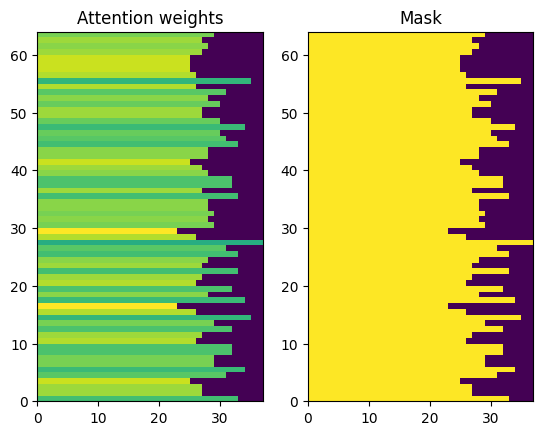

In [29]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [30]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [31]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [32]:
decoder = Decoder(target_text_processor, UNITS)

In [33]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 37, 512)
input target tokens shape: (batch, t) (64, 245)
logits shape shape: (batch, target_vocabulary_size) (64, 245, 1391)


In [34]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [35]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [36]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [37]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'unnecessary wait wattsexplanationthe highpredicted likewise updates manageable advised 429 generator',
       b'slightly adjusting clouds highly clientdear interruptions their potentially invest concern',
       b'water constantino informed [UNK] interruption strongly schedule average elements 32'],
      dtype=object)

In [38]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [39]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 37)
Target tokens, shape: (batch, t) (64, 245)
logits, shape: (batch, t, target_vocabulary_size) (64, 245, 1391)


In [40]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [41]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [42]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [43]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()
{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 7.237778, 'expected_acc': 0.0007189072609633358}

In [44]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 7.237778, 'expected_acc': 0.0007189072609633358}

In [45]:
model.evaluate(val_ds, steps=20, return_dict=True)

2023-04-13 17:57:10.683539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype string
	 [[{{node Placeholder/_17}}]]
2023-04-13 17:57:10.683924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype int64
	 [[{{node Placeholder/_16}}]]


20/20 [==============================] - 6s 27ms/step - loss: 7.2519 - masked_acc: 8.0659e-04 - masked_loss: 7.2530


{'loss': 7.251911640167236,
 'masked_acc': 0.00080658815568313,
 'masked_loss': 7.253024578094482}

In [46]:
history = model.fit(
    train_ds.repeat(), 
    epochs=1,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

2023-04-13 17:57:16.431848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype int64
	 [[{{node Placeholder/_16}}]]
2023-04-13 17:57:16.432372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype resource
	 [[{{node Placeholder/_11}}]]
2023-04-13 17:57:18.914001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape 

100/100 [==============================] - 338s 3s/step - loss: 1.9712 - masked_acc: 0.5781 - masked_loss: 1.9709 - val_loss: 1.4697 - val_masked_acc: 0.6512 - val_masked_loss: 1.4115


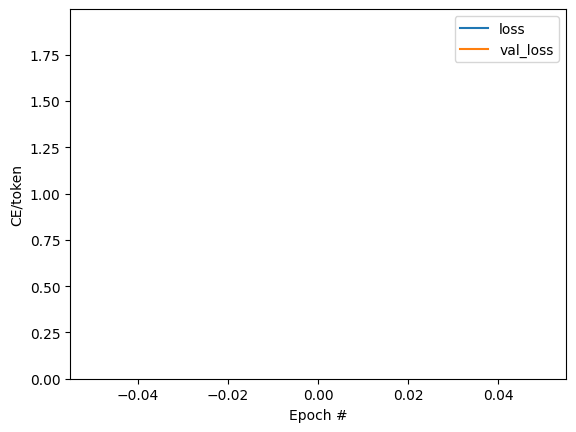

In [47]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

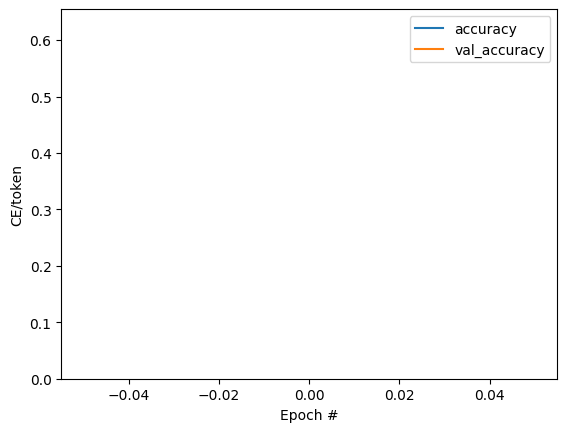

In [48]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [49]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=700,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

2023-04-13 18:02:57.455719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-13 18:02:57.457482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-13 18:02:57.459077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-04-13 18:02:59.997195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-13 18:02:59.999490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-13 18:03:00.001107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-04-13 18:03:10.319665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_0' with dtype float and shape [?,?,?]
	 [[{{node inputs_0}}]]
2023-04-13 18:03:10.330333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_0' with dtype float and shape [?,?,?]
	 [[{{node inputs_0}}]]
2023-04-13 18:03:10.439487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{n

INFO:tensorflow:Assets written to: seq2seq_model.sav/assets


INFO:tensorflow:Assets written to: seq2seq_model.sav/assets


In [52]:
"""
model.save("seq2seq_model.sav")
loaded_1 = tf.keras.models.load_model(
    "seq2seq_model.sav", custom_objects={"CustomModel": Translator}
)
"""

RuntimeError: Unable to restore object of class 'TextVectorization'. One of several possible causes could be a missing custom object. Decorate your custom object with `@keras.utils.register_keras_serializable` and include that file in your program, or pass your class in a `keras.utils.CustomObjectScope` that wraps this load call. 

Exception: Error when deserializing class 'TextVectorization' using config={'name': 'text_vectorization', 'trainable': True, 'dtype': 'string', 'batch_input_shape': (None,), 'max_tokens': 5000, 'standardize': 'tf_lower_and_split_punct', 'split': 'whitespace', 'ngrams': None, 'output_mode': 'int', 'output_sequence_length': None, 'pad_to_max_tokens': False, 'sparse': False, 'ragged': True, 'vocabulary': None, 'idf_weights': None, 'encoding': 'utf-8', 'vocabulary_size': 114, 'has_input_vocabulary': False}.

Exception encountered: Unkown value for `standardize` argument of layer TextVectorization. If restoring a model and `standardize` is a custom callable, please ensure the callable is registered as a custom object. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details. Allowed values are: `None`, a `Callable`, or one of the following values: ('lower_and_strip_punctuation', 'lower', 'strip_punctuation'). Received: tf_lower_and_split_punct

In [ ]:
"""
'7 October 2023 15 Ema high 10.143 dewpoint nan positive contribution nan 0.0 nan 0.0 2.0 nan'
 '8 June 2023 16 Ana medium 2.8 temperature nan negative impact nan 2.0 1.0 nan nan 0.0'
 '27 February 2023 14 Ema high 9.429 dewpoint temperature positive contribution positive contribution nan 0.0 0.0 nan 0.0'
 '28 November 2023 15 Ana very high 13.857 solar radiation nan significant positive contribution nan 1.0 0.0 0.0 0.0 nan'
 '6 April 2024 6 Diana low 3.429 solar radiation hourly precipitation negative impact significant negative impact 2.0 nan 0.0 nan nan'
 '26 October 2023 14 Ana medium 3.733 hourly precipitation nan negative impact nan nan 2.0 nan 2.0 nan'
 '14 April 2024 11 Carlos very high 3.28 solar radiation temperature significant positive contribution positive contribution 0.0 0.0 nan nan 0.0'
 '14 June 2023 14 Ema high 2.48 dewpoint solar radiation positive contribution positive contribution nan nan 0.0 nan 0.0'
 '1 January 2024 15 Ema high 2.72 temperature nan positive contribution nan 0.0 1.0 2.0 nan 0.0'
 '6 July 2023 19 Ema very low 0.714 solar radiation nan significant negative impact nan nan nan nan nan 2.0'
 '16 February 2023 9 Ana very low 1.133 solar radiation nan significant negative impact nan 2.0 2.0 2.0 2.0 1.0'
 '17 December 2023 8 Ricardo very low 0.16 solar radiation nan significant negative impact nan 2.0 2.0 2.0 1.0 nan'
 '13 November 2024 11 Diana medium 3.267 temperature nan negative impact nan 1.0 2.0 0.0 nan nan'
 '9 March 2024 18 Carlos high 4.867 solar radiation nan positive contribution nan nan 0.0 2.0 0.0 1.0'
 '26 June 2024 19 Ricardo very low 0.04 solar radiation nan significant negative impact nan nan 2.0 nan 2.0 1.0'
 '6 March 2023 14 Ema high 10.0 temperature nan positive contribution nan nan 0.0 nan 0.0 0.0'
 '21 February 2024 8 Tomás low 4.0 solar radiation nan negative impact nan 1.0 2.0 0.0 2.0 nan'
 '7 February 2024 13 Ema medium 8.0 hourly precipitation temperature negative impact negative impact 2.0 0.0 2.0 0.0 1.0'
 '21 January 2023 8 Diana low 1.6 hourly precipitation nan significant negative impact nan nan 1.0 nan nan 2.0'
 '16 May 2024 19 Ema very low 1.067 solar radiation nan significant negative impact nan 2.0 nan 2.0 2.0 1.0'
 '14 May 2023 10 Tomás high 5.0 temperature dewpoint positive contribution positive contribution nan 2.0 nan 0.0 0.0'
 '19 September 2023 20 Ema very low 0.867 solar radiation nan significant negative impact nan nan 2.0 2.0 nan 2.0'
 '18 January 2024 19 Tomás very low 0.067 solar radiation nan significant negative impact nan 1.0 nan 2.0 2.0 nan'
 '21 May 2024 13 Ana medium 6.286 temperature nan negative impact nan nan nan 2.0 2.0 1.0'
 '14 October 2024 13 Ema medium 6.714 temperature nan negative impact nan nan nan 1.0 nan 0.0'
"""

result = model.translate(['14 April 2024 11 Carlos very high 3.28 solar radiation temperature significant positive contribution positive contribution 0.0 0.0 nan nan 0.0']) # Are you still home
print(len(result[0].numpy().decode()))
result[0].numpy().decode()